# Make Argand plot for unsupported MoS$_2$

The Argand plot shows the complex values of the wave function at the peaks corresponding to atomic columns.

## Run this to import the needed packages and functions

In [1]:
%matplotlib notebook
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
### import the desired neural network09080
###
from temnn.data.dataset import DataEntry,DataSet
# Peak detection
#from stm.preprocess import normalize
from temnn.data.mods import local_normalize
from stm.feature.peaks import find_local_peaks, refine_peaks
from skimage.morphology import disk
from scipy.spatial import cKDTree as KDTree
import sys
import os
import json
from collections import deque
from multiprocessing import Pool
import ase.io
import skimage.io

num_gpus = 1
batch_size = 1 * num_gpus

/home/modules/software/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/site-packages/cryptography/hazmat/bindings/openssl/binding.py:173: CryptographyDeprecationWarning: OpenSSL version 1.0.2 is no longer supported by the OpenSSL project, please upgrade. The next version of cryptography will drop support for it.
  warnings.warn(


# Choose the dataset you want to draw images from

In [2]:
# Uncomment the dataset you want
data_dir = "../workflow/simulation_data/MoS2_15pm-test/"

# Path to the trained network
folder = '../workflow/trained_networks/MoS2_15pm'


## Load data and compute predictions


In [3]:
# load the network path and the parameters
model_path = os.path.join(folder, 'model-0')
#model_path = os.path.join(folder, 'checkpoint-0135')

# load the network
print('Loading model', model_path)
model = keras.models.load_model(model_path)

parameters = json.load(open(os.path.join(data_dir, 'parameters.json')))
parameters['debug'] = False

# load the data
image_size = parameters['image_size']
sampling = np.mean(parameters['sampling'])
#netparam = parameters['netparam']
normalizedistance = parameters['normalizedistance'] / sampling

print("Classes:", parameters['num_classes'])
print("Image size:", image_size)
print("Sampling:", sampling)

Loading model ../workflow/trained_networks/MoS2_15pm/model-0
Classes: 2
Image size: [640, 640]
Sampling: 0.10500000000000001


## Select an image
And load it

In [4]:
imagenumber = '000_0608'
tmp = np.load(os.path.join(data_dir, 'images_labels', 'image_label_'+imagenumber+'.npz'))
image = tmp['image']
wave = tmp['label']

# Read the atoms
atoms = ase.io.read(os.path.join(data_dir, 'model', 'model_'+imagenumber.split('_')[1]+'.traj'))
#formula = atoms.info['prototype']
full_formula = atoms.get_chemical_formula()
#print(formula)
print(full_formula)

# Load the image, if present
try:
    raytraced = skimage.io.imread('MoS2_reg_'+imagenumber.split('_')[1]+'.png')
    # Some images are flipped - needs to be done manually
    # raytraced = raytraced[:,::-1]
except FileNotFoundError:
    raytraced = None
    
def rmse(a):
    return np.sqrt(np.mean(a*a))

print("Normalizing")
normimage = local_normalize(image.copy(), normalizedistance, normalizedistance)
print("Predicting")
predictions = model.predict(normimage)
print(wave.shape, wave.dtype, predictions.shape, predictions.dtype)
diff = np.abs(wave - predictions)
print("RMSE:  Re = {}    Im = {}".format(rmse(diff[...,0]), rmse(diff[...,1])))
diff = abs(diff)
print("Worst difference:", diff.max())
print("   at position", np.unravel_index(diff.argmax(), diff.shape), "of", diff.shape)

# Scales for the plots
maxval = max(wave[0,:,:,:].max(), predictions[0,:,:,:].max())
minval = min(wave[0,:,:,:].min(), predictions[0,:,:,:].min())
print("Values in [{}, {}]".format(minval, maxval))
maxval = symval = max(-minval, maxval)
maxval = 1.08
minval = -maxval

# Find the worst position at least 20 pixels from the edge
edge = 20
#worstpos = np.unravel_index(np.abs(wave - predictions).argmax(), wave.shape)[1:3]
err = np.abs(wave - predictions)[0,edge:-edge,edge:-edge,:]
worstpos = np.unravel_index(err.argmax(), err.shape)[:2]
worstpos = np.array(worstpos) + edge
print("Worst postion", worstpos)
center = np.array(wave.shape[1:3]) // 2


Mo331S601
Normalizing
Predicting
(1, 640, 640, 2) float32 (1, 640, 640, 2) float32
RMSE:  Re = 0.004515122156590223    Im = 0.00747173884883523
Worst difference: 0.280496
   at position (0, 0, 307, 1) of (1, 640, 640, 2)
Values in [-0.10965010523796082, 0.7298484444618225]
Worst postion [293 416]


## Make a plot of the wave functions for informational purposes.

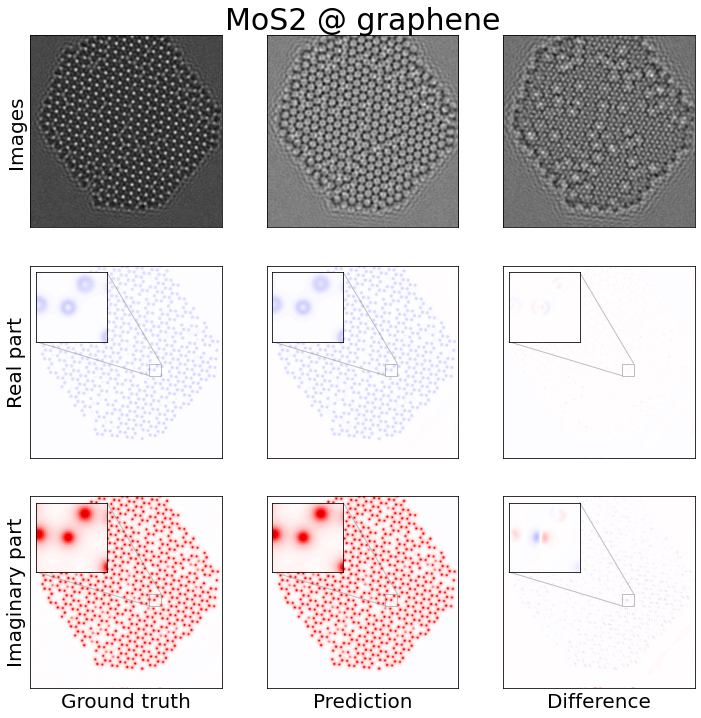

In [5]:

# Actual plotting
cmap = 'seismic'
zoom = True
if zoom:
    def myplot(ax, data, **kwargs):
        ax.imshow(data, origin='lower', **kwargs)
        ax.set_xticks([])
        ax.set_yticks([])
        # Make insert, depending on where the maximum is
        d = 0.03
        s = 0.4
        x = worstpos - center
        #print(worstpos, center, x)
        if x[0] < 0 and x[1] < 0:
            pos = [1 - s, 1 - s]
        elif x[0] >= 0 and x[1] < 0:
            pos = [1 - s, d]
        elif x[0] < 0 and x[1] >= 0:
            pos = [d, 1 - s]
        else:
            pos = [d, d]
        ins = ax.inset_axes(pos + [s - d, s - d])
        ins.imshow(data, origin='lower', **kwargs)
        ins.set_xlim(worstpos[1] - 20, worstpos[1] + 20)
        ins.set_ylim(worstpos[0] - 20, worstpos[0] + 20)
        ins.set_xticks([])
        ins.set_yticks([])
        ax.indicate_inset_zoom(ins)
else:
    def myplot(ax, data, **kwargs):
        ax.imshow(data, **kwargs)
        ax.set_xticks([])
        ax.set_yticks([])
        
# Actual plotting
fig, ax = plt.subplots(3,3,figsize=(12,12))
for i in range(3):
    if i < 2 or raytraced is None:
        ax[0][i].imshow(image[0,:,:,i], origin='lower', cmap='gray')
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
if raytraced is not None:
    ax[0][2].imshow(raytraced[45:-35,45:-35])

ax[0][0].set_ylabel('Images', fontsize=20)
#ax[0][1].set_title('{}  ({})'.format(formula, full_formula), fontsize=30)
ax[0][1].set_title('MoS2 @ graphene', fontsize=30)
for i in range(2):
    myplot(ax[i+1][0], wave[0,:,:,i], 
           cmap=cmap, vmax = maxval, vmin = minval)
    myplot(ax[i+1][1], predictions[0,:,:,i], 
           cmap=cmap, vmax = maxval, vmin = minval)
    myplot(ax[i+1][2], wave[0,:,:,i]-predictions[0,:,:,i], 
           cmap=cmap, vmax = symval, vmin = -symval)
ax[1][0].set_ylabel('Real part', fontsize=20)
ax[2][0].set_ylabel('Imaginary part', fontsize=20)
ax[2][0].set_xlabel('Ground truth', fontsize=20)
ax[2][1].set_xlabel('Prediction', fontsize=20)
ax[2][2].set_xlabel('Difference', fontsize=20)
#plt.tight_layout()
#plt.savefig('MoS2combined_'+imagenumber.split('_')[1]+'.png', dpi=300)
None  

In [6]:
rmse_re = np.sqrt(np.mean((predictions - wave)[...,0]**2))
rmse_im = np.sqrt(np.mean((predictions - wave)[...,1]**2))
rmse = np.sqrt(np.mean((predictions - wave)**2))
print("RMSE:", rmse_re, rmse_im, rmse)

RMSE: 0.004515122 0.007471739 0.0061730547


## Find the "peaks" in the signal

We now find the peaks in the signal, and try to split them into two sublattices.  After splitting into A and B sublattices, we cannot *a priori* know which is Mo sites and which is S sites, but must verify this manually by visual inspection of the atomic structure.

In [7]:
signal = np.sqrt(predictions[0,:,:,0]**2+predictions[0,:,:,1]**2)
print(signal.shape)
wavesignal = np.sqrt(wave[0,:,:,0]**2+wave[0,:,:,1]**2)
print(wavesignal.shape)

(640, 640)
(640, 640)


In [8]:
peaks = find_local_peaks(signal, min_distance=10, 
                         threshold=0.30, exclude_border=10,
                         exclude_adjacent=True).astype(int)
wavepeaks = find_local_peaks(wavesignal, min_distance=10, 
                         threshold=0.30, exclude_border=10,
                         exclude_adjacent=True).astype(int)
print(len(peaks), len(wavepeaks))

628 628


### Split the peaks into A and B lattices.  

First we should know the approximate lattice constant.

**IMPORTANT:** This script cannot itself figure out which sublattice is Mo and which is S.  It it gets it wrong, switch ``True`` to ``False`` (or the other way) in **both** calls to ``classify()`` below.

In [9]:
latconst = 3.184
distance = latconst / np.sqrt(3) / sampling
print(distance, 'pixels')

def classify(points, n, group, sublat, tree):
    sublat[n] = group
    neighbors = tree.query(points[n], k=4,
                           distance_upper_bound=1.3*distance)[1]
    for nb in neighbors:
        if nb < len(sublat) and sublat[nb] == -1:
            classify(points, nb, not group, sublat, tree)

sublattice = -np.ones(len(peaks), int)
tree = KDTree(peaks)
startpoint = np.argmax(peaks[:,1])  # Highest y value
print("Starting point:", startpoint, peaks[startpoint])
classify(peaks, startpoint, False, sublattice, tree)

wavesublattice = -np.ones(len(wavepeaks), int)
tree = KDTree(wavepeaks)
startpoint = np.argmax(wavepeaks[:,1])  # Highest y value
print("Starting point:", startpoint, wavepeaks[startpoint])
classify(wavepeaks, startpoint, False, wavesublattice, tree)


17.507459591426368 pixels
Starting point: 364 [388 625]
Starting point: 361 [387 625]


In [10]:
sublattice

array([-1,  0,  1,  0,  1,  0,  1,  0,  1,  1,  0,  1,  0,  1,  0,  0,  1,
        1,  0,  0,  1,  1,  0,  1,  0,  1,  0,  0,  1,  0,  1,  0,  1,  0,
        1,  0,  1,  0,  0,  1,  0,  1,  0,  0,  0,  1,  0,  1,  1,  1,  0,
        1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  0,  1,  0,
        1,  0,  1,  0,  0,  1,  1,  0,  1,  0,  1,  0,  0,  1,  0,  1,  0,
        0,  1,  1,  0,  0,  1,  0,  1,  1,  1,  0,  1,  0,  1,  1,  0,  1,
        0,  1,  0,  0,  1,  0,  1,  1,  0,  1,  1,  0,  0,  1,  0,  1,  0,
        0,  1,  1,  0,  1,  0,  1,  0,  0,  1,  0,  1,  1,  0,  0,  1,  1,
        0,  0,  0,  1,  1,  1,  0,  0,  1,  0,  1,  0,  0,  1,  0,  1,  1,
        0,  0,  1,  0,  1,  1,  0,  1,  0,  1,  1,  0,  1,  0,  0,  1,  0,
        1,  0,  1,  0,  1,  0,  0,  0,  1,  1,  1,  0,  0,  1,  0,  1,  1,
        0,  1,  1,  0,  1,  0,  0,  1,  1,  1,  0,  0,  0,  0,  1,  1,  1,
        0,  0,  0,  1,  1,  1,  0,  1,  0,  1,  0,  0,  0,  1,  0,  1,  1,
        0,  0,  0,  1,  0

(628, 2) (320, 2) (306, 2)


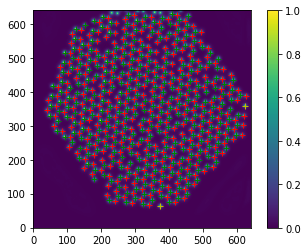

In [11]:
plt.imshow(signal, origin='lower')
#plt.scatter(peaks[:,1], peaks[:,0], c='w', marker='+', linewidth=1.0)
apeaks = peaks[sublattice == 0]
bpeaks = peaks[sublattice == 1]
cpeaks = peaks[sublattice == -1]
print(peaks.shape, apeaks.shape, bpeaks.shape)
plt.scatter(apeaks[:,1], apeaks[:,0], c='r', marker='+', linewidth=1.0)
plt.scatter(bpeaks[:,1], bpeaks[:,0], c='g', marker='+', linewidth=1.0)
if len(cpeaks):
    plt.scatter(cpeaks[:,1], cpeaks[:,0], c='y', marker='+', linewidth=1.0)
plt.colorbar()

(628, 2) (320, 2) (306, 2)


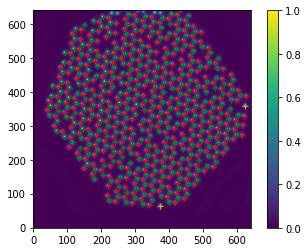

In [12]:
plt.imshow(signal, origin='lower')
#plt.scatter(peaks[:,1], peaks[:,0], c='w', marker='+', linewidth=1.0)
apeaks = wavepeaks[wavesublattice == 0]
bpeaks = wavepeaks[wavesublattice == 1]
cpeaks = wavepeaks[wavesublattice == -1]
print(peaks.shape, apeaks.shape, bpeaks.shape)
plt.scatter(apeaks[:,1], apeaks[:,0], c='r', marker='+', linewidth=1.0)
plt.scatter(bpeaks[:,1], bpeaks[:,0], c='g', marker='+', linewidth=1.0)
if len(cpeaks):
    plt.scatter(cpeaks[:,1], cpeaks[:,0], c='y', marker='+', linewidth=1.0)
plt.colorbar()

### Isolated atoms needs to be handled manually

In [13]:
corrected = [1, 0]  # Desired classes
for i in corrected:
    idx = np.argmin(sublattice)
    assert sublattice[idx] == -1
    sublattice[idx] = i
    idx = np.argmin(wavesublattice)
    assert wavesublattice[idx] == -1
    wavesublattice[idx] = i
#sublattice[sublattice == -1] = 0
#wavesublattice[wavesublattice == -1] = 0

### Find the complex values at each peak, as an average of a 3x3 pixel region.

In [14]:
pvalues = np.zeros((len(peaks),2))
for i, (x, y) in enumerate(peaks):
    re = np.mean(predictions[0,x-2:x+3,y-2:y+3,0])
    im = np.mean(predictions[0,x-2:x+3,y-2:y+3,1])
    pvalues[i] = (re, im)
wavevalues = np.zeros((len(wavepeaks),2))
for i, (x, y) in enumerate(wavepeaks):
    re = np.mean(wave[0,x-2:x+3,y-2:y+3,0])
    im = np.mean(wave[0,x-2:x+3,y-2:y+3,1])
    wavevalues[i] = (re, im)

In [15]:
pvalues[0]

array([-0.07444844,  0.53393847])

(0.2, 1.0)

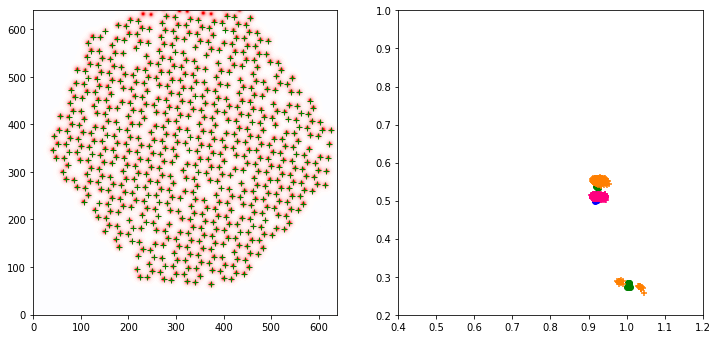

In [16]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(predictions[0,:,:,1], origin='lower', cmap=cmap, vmax = maxval, vmin = minval)
ax[0].scatter(peaks[:,1], peaks[:,0], c='g', marker='+', linewidth=1.0)
slat = sublattice == 1
molat = sublattice == 0
ax[1].scatter(1+pvalues[molat,0], pvalues[molat,1], c='b', label='Mo')
ax[1].scatter(1+pvalues[slat,0], pvalues[slat,1], c='g', label='S')
#ax[1].scatter(1+wavevalues[:,0], wavevalues[:,1], marker='+', c='r')
slat = wavesublattice == 1
molat = wavesublattice == 0
ax[1].scatter(1+wavevalues[molat,0], wavevalues[molat,1], marker='+', c='#FF007F')
ax[1].scatter(1+wavevalues[slat,0], wavevalues[slat,1], marker='+', c='#FF7F00')
ax[1].set_aspect(1.0)
ax[1].set_xlim(0.4,1.2)
ax[1].set_ylim(0.2,1.0)

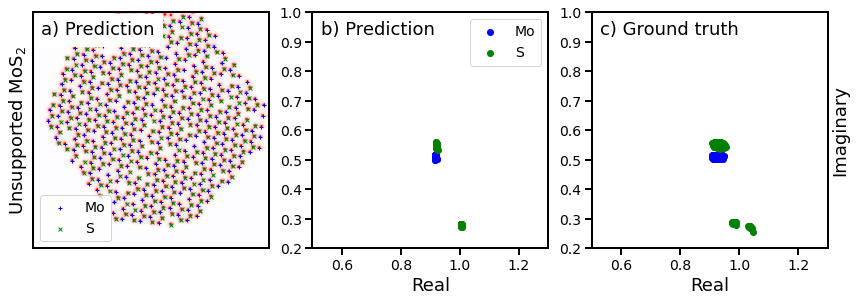

In [17]:
fontsize=18

fig, ax = plt.subplots(1,3,figsize=(12,4.5))
ax[0].imshow(predictions[0,:,:,1], origin='lower', cmap=cmap, vmax = maxval, vmin = minval)
ax[0].scatter(peaks[sublattice==0,1], peaks[sublattice==0,0], c='b', 
              marker='+', s=15, linewidth=1.0, label='Mo')
ax[0].scatter(peaks[sublattice==1,1], peaks[sublattice==1,0], c='g', 
              marker='x', s=15, linewidth=1.0, label='S')
slat = sublattice == 1
molat = sublattice == 0
ax[1].scatter(1+pvalues[molat,0], pvalues[molat,1], c='b', label='Mo')
ax[1].scatter(1+pvalues[slat,0], pvalues[slat,1], c='g', label='S')
#ax[1].scatter(1+wavevalues[:,0], wavevalues[:,1], marker='+', c='r')
slat = wavesublattice == 1
molat = wavesublattice == 0
ax[2].scatter(1+wavevalues[molat,0], wavevalues[molat,1], c='b')
ax[2].scatter(1+wavevalues[slat,0], wavevalues[slat,1], c='g')
for i in (1,2):
    ax[i].set_aspect(1.0)
    ax[i].set_xlim(0.5,1.3)
    ax[i].set_ylim(0.2,1.0)
    #ax[i].set_xlim(0.95,1.05)
    #ax[i].set_ylim(0.3,0.4)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
#ax[0].axis('off')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_ylabel("Unsupported MoS$_2$", fontsize=fontsize)
ax[1].set_xlabel('Real', fontsize=fontsize)
ax[2].set_xlabel('Real', fontsize=fontsize)
ax[2].set_ylabel('Imaginary', fontsize=fontsize)
ax[2].yaxis.set_label_position("right")
for i, t in enumerate(['a) Prediction', 'b) Prediction', 'c) Ground truth']):
    # y = 0.97 inside or 1.1 outside
    ax[i].text(0.035, 0.965, t, horizontalalignment='left', backgroundcolor='w',
          verticalalignment='top', transform=ax[i].transAxes, fontsize=fontsize)
    [s.set_linewidth(2) for s in ax[i].spines.values()]
for i in range(1,3):
    ax[i].tick_params(axis='both', which='major', labelsize=14, length=7, width=2)
plt.tight_layout()
plt.savefig('Argand_MoS2unsup_'+imagenumber.split('_')[1]+'.png', dpi=300)
None 